# The search for allopatric speciation in the gut microbial communities of Tanganyikan cichlids

## An adventure in fish poo.

*Russell Neches*

### Import OTU table, sample metadata and host tree

We use python's biom module to extract the OTU counts from the .biom file QIIME gave us. In principle, we could use the biom object to do various slicing and dicing, but the module is confusing and weird. So, we just shove the OTU counts into a pandas dataframe and move on.

Next, we import the sample metadata, which we use to drop the control samples and the other experiments, and to merge the OTU counts for samples that have the same host species.

Last, we use rpy2 to import the host phylogeny. This is silly, but all of the tests for phylogenetic signal are in R, so we need to have the host tree as an R object.

Required python packages :
* `biom-format`
* `pandas`
* `seaborn`
* `dendropy`

Required R packages :
* `ape`
* `phytools`
* `phylobase`
* `adephylo`

### On phylogenetic signal

> The concept of phylogenetic signal is at the heart of most phylogenetic
> methods. From a statistical point of view, a phylogenetic signal is 
> defined by the non-null covariances (i.e., non-independence) among species.
> From a biological point of view, phylogenetic signal is a direct consequence
> of the evolution of traits and its form will depend on teh evolutionary
> mechanisms in action.
>
> Emmanuael Paradis, *Analysis of phylogenetics and evolution with R*, p. 236

In [1]:
%pylab inline
%load_ext retina

Populating the interactive namespace from numpy and matplotlib


In [51]:
from IPython.display import display, Image
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(16, 4))

for root, _, files in os.walk('host_phenotypes') :
    for n,file in enumerate(files) :
        i =  mpimg.imread('host_phenotypes/' + file )
        subplot(2,7,n)
        plt.imshow(i)
        text( 0, 500, file.replace('_','\n').replace('.png',''), style='italic' )
        plt.axis('off')
        
#plt.tight_layout()

### Chimera detection, clustering and OTU counting

Here, we use [`vsearch`](https://zenodo.org/record/16153) to perform these tasks.

In [ ]:
! vsearch --threads 48 --uchime_ref fishpoo.fasta.gz \
--db ../SILVA_123_SSURef_tax_silva_trunc.fasta.gz    \
--chimeras fishpoo_chimeras.fasta                    \
--nonchimeras fishpoo_nochimeras.fasta

! gzip fishpoo_chimeras.fasta
! gzip fishpoo_nochimeras.fasta

    vsearch v1.8.1_linux_x86_64, 47.2GB RAM, 16 cores
    https://github.com/torognes/vsearch
    
    Reading file ../SILVA_123_SSURef_tax_silva_trunc.fasta.gz 100%
    2489280089 nt in 1756783 seqs, min 900, max 3718, avg 1417
    Counting unique k-mers 100%
    Creating index of unique k-mers 100%
    Detecting chimeras 71%

In [ ]:
!vsearch --cluster_fast fishpoo_nochimeras.fasta.gz \
--id 0.99                                           \
--threads 16                                        \
--uc fishpoo.uc                                     \
--centroids fishpoo_centroids.fasta                 \
--consout fishpoo_consensus.fasta 

    vsearch v1.8.1_linux_x86_64, 47.2GB RAM, 16 cores
    https://github.com/torognes/vsearch
    
    Reading file fishpoo_nochimeras.fasta.gz 100%
    2011941945 nt in 7954947 seqs, min 106, max 509, avg 253
    Masking 100%
    Sorting by length 100%
    Counting unique k-mers 100%
    Clustering 100%
    Sorting clusters 100%
    Writing clusters 100%
    Clusters: 194733 Size min 1, max 3747815, avg 40.9
    Singletons: 141869, 1.8% of seqs, 72.9% of clusters
    Multiple alignments 100%

For parsing the [uclust-style clustering output](http://www.drive5.com/usearch/manual/ucout.html) :

* **H** : Hit. Represents a query-target alignment. For clustering, indicates the cluster assignment for the query. If ‑maxaccepts > 1, only there is only one H record giving the best hit. To get the other accepts, use another type of output file, or use the ‑uc_allhits option (requires version 6.0.217 or later).
* **S** : Centroid (clustering only). There is one S record for each cluster, this gives the centroid (representative) sequence label in the 9th field. Redundant with the C record; provided for backwards compatibility.
* **C**	: Cluster record (clustering only). The 3rd field is set to the cluster size (number of sequences in the cluster) and the 9th field is set to the label of the centroid sequence.

In [4]:
import gzip
import pandas as pd

OTUs = {}
for n,line in enumerate(gzip.open( 'fishpoo.uc.gz' )) :
    if line.split('\t')[0] == 'H' :
        # and also their hits
        hit, centroid = line.strip().split('\t')[8:10]
        hit = hit.split('_')[0]
        if not OTUs.has_key( centroid ) : OTUs[centroid] = [ centroid.split('_')[0] ]
        OTUs[centroid].append(hit)

In [44]:
# OTU list, sorted largest to smallest
otu_list = sorted(OTUs.keys(), key=lambda otu: len(OTUs[otu]))[::-1]
mapping = pd.DataFrame.from_csv('fishpoo_map.tsv', sep='\t')
otu_table = pd.DataFrame( index=mapping.index )

for otu in otu_list :
    otu_table[ otu ] = 0

for sample in otu_table.index :
    for otu in otu_list :
        otu_table.ix[sample][otu] = OTUs[otu].count(sample)

In [48]:
phase_1 = mapping[mapping.Experiment == 'Phase I']

# drop the samples that aren't fish
phase_1 = phase_1.drop(['KITCNT1', 'CHARCNT', 'WATERCNT', 'FOOD', 'Neg.Control.1'])

# Take the OTU counts for host taxa with more than one 
# individual, and merge them (basically, and inner join),
# and then normalize the OTU counts for each taxa to 1
otu_table = pd.merge( otu_table, 
                      pd.DataFrame(phase_1['Host']), 
                      right_index=True, 
                      left_index=True ).groupby('Host').sum()
otu_table = otu_table.div( otu_table.sum(axis=1), axis=0)

### Remove extremely rare OTUs

Remove the extremely rare OTUs and create a fasta file for the aligner.

In [ ]:
non_rare_otus = []
for otu in otu_list :
    if sum(otu_table[otu])/14 > 0.00001 :
        non_rare_otus.append( otu )
print 'non-rare OTUs : ' + str(len( non_rare_otus ))

In [73]:
import screed
from screed import ScreedDB

screed.read_fasta_sequences('fishpoo_centroids.fasta.gz')
db = ScreedDB('fishpoo_centroids.fasta.gz')

centroid_seqs = []
with open( 'fishpoo_nonrare_otus.fasta', 'w' ) as f :
    for otu in non_rare_otus :
        c = db[otu]
        centroid_seqs.append( c )
        f.write( '> ' + str(c.name) + '\n' + str(c.sequence) + '\n' )

### Build rRNA alignment with ssu-align

In [ ]:
!ssu-align fishpoo_nonrare_otus.fasta fishpoo_ssu

In [ ]:
# ssu-align produces Stockholm-formatted alignments, but
# RAxML can only read PHYLIP alignments. Unfortunately,
# Biopython can't write PHYLIP without truncating the names.
# So... we write alignment fasta...
from Bio import AlignIO
from Bio.Alphabet import NucleotideAlphabet, Gapped

al = AlignIO.parse( open( 'fishpoo_ssu.bacteria.stk' ), 'stockholm', alphabet=Gapped(NucleotideAlphabet) )
AlignIO.write(al, open( 'fishpoo_ssu.bacteria.fasta', 'w' ), 'fasta' )

In [20]:
import screed
from screed import ScreedDB

# ...and then generate PHYLIP manually so so RAxML can read it
screed.read_fasta_sequences('fishpoo_ssu.bacteria.align.fa')
db = ScreedDB('fishpoo_ssu.bacteria.align.fa')
aligned_centroid_seqs = []
with open( 'fishpoo_ssu.bacteria.align.phylip', 'w' ) as f :
    f.write( str(len(db.keys())) + ' ' + str( len(db.items()[0][1]['sequence']) ) + '\n' )
    for otu in db.keys() :
        c = db[otu]
        aligned_centroid_seqs.append( c )
        # all aboard the derp-train...
        f.write( str(c.name) + ' ' + str(c.sequence) + '\n' )

### Build trees with RAxML

In [ ]:
!standard-RAxML/raxmlHPC-PTHREADS-SSE3 \
-s fishpoo_ssu.bacteria.align.phylip   \
-n fishpoo_ssu.raxml                   \
-m GTRGAMMA                            \
-T 16                                  \
-p 314159

In [21]:
%load_ext rpy2.ipython

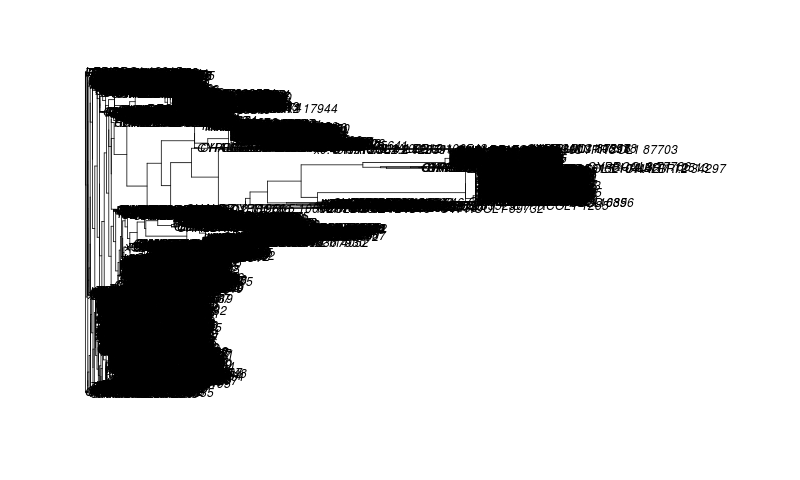

In [23]:
%%R -w 800 -h 480 -u px
library(ape)

otu_tree <- read.tree("RAxML_bestTree.fishpoo_ssu.raxml")
plot(otu_tree)